## Splink deduplication demo 

In this demo we de-duplicate a small dataset.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

conf=SparkConf()

# Load in a jar that provides extended string comparison functions such as Jaro Winkler.
# Splink 
conf.set('spark.driver.extraClassPath', 'jars/scala-udf-similarity-0.0.6.jar')
conf.set('spark.jars', 'jars/scala-udf-similarity-0.0.6.jar')   


# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf.set('spark.driver.memory', '4g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession(sc)

 # Register UDFs
from pyspark.sql import types
spark.udf.registerJavaFunction('jaro_winkler_sim', 'uk.gov.moj.dash.linkage.JaroWinklerSimilarity', types.DoubleType())
spark.udf.registerJavaFunction('Dmetaphone', 'uk.gov.moj.dash.linkage.DoubleMetaphone', types.StringType())

## Step 2:  Read in data

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](https://robinlinacre.com/simple_sparklink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/dev/splink/files/settings_jsonschema.json).  




In [5]:
settings = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
        "l.dob = r.dob"
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"]
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- We are going generate comparisons subject to the blocking rules contained in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [6]:
from splink import Splink

linker = Splink(settings, spark, df=df)
df_e = linker.get_scored_comparisons()
df_e.persist()  # Later, we will make term frequency adjustments.  Persist caches these results in memory, preventing them having to be recomputed when we make these adjustments.

INFO:splink.iterate:Iteration 0 complete
INFO:splink.iterate:Iteration 1 complete
INFO:splink.iterate:Iteration 2 complete
INFO:splink.iterate:Iteration 3 complete
INFO:splink.iterate:Iteration 4 complete
INFO:splink.iterate:Iteration 5 complete
INFO:splink.iterate:Iteration 6 complete
INFO:splink.iterate:Iteration 7 complete
INFO:splink.iterate:Iteration 8 complete
INFO:splink.iterate:Iteration 9 complete


DataFrame[match_probability: double, unique_id_l: bigint, unique_id_r: bigint, first_name_l: string, first_name_r: string, gamma_first_name: int, prob_gamma_first_name_non_match: double, prob_gamma_first_name_match: double, surname_l: string, surname_r: string, gamma_surname: int, prob_gamma_surname_non_match: double, prob_gamma_surname_match: double, dob_l: string, dob_r: string, gamma_dob: int, prob_gamma_dob_non_match: double, prob_gamma_dob_match: double, city_l: string, city_r: string, gamma_city: int, prob_gamma_city_non_match: double, prob_gamma_city_match: double, email_l: string, email_r: string, gamma_email: int, prob_gamma_email_non_match: double, prob_gamma_email_match: double, group_l: bigint, group_r: bigint]

## Step 5: Inspect results 



In [14]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["match_probability","unique_id_l","unique_id_r","group_l", "group_r", "first_name_l","first_name_r","surname_l","surname_r","dob_l","dob_r","city_l","city_r","email_l","email_r",]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)

,match_probability,unique_id_l,unique_id_r,group_l,group_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r
2,0.997613,0,1,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-07-31,London,London,hannah88@powers.com,hannah88@powers.com
1,0.997613,0,2,0,0,Julia,Julia,None,Taylor,2015-10-29,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
0,0.999962,0,3,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
4,0.997146,1,2,0,0,Julia,Julia,Taylor,Taylor,2015-07-31,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
3,0.984606,1,3,0,0,Julia,Julia,Taylor,Taylor,2015-07-31,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
2290,0.036772,1,89,0,18,Julia,Chirla,Taylor,Taylor,2015-07-31,2006-06-28,London,London,hannah88@powers.com,mbrooks@booker.com
2289,0.036772,1,142,0,26,Julia,Harry,Taylor,Taylor,2015-07-31,2017-11-24,London,London,hannah88@powers.com,coltonray@lee.com
2288,0.036772,1,148,0,26,Julia,Harry,Taylor,Taylor,2015-07-31,2017-09-01,London,London,hannah88@powers.com,coltonray@lee.com
4821,0.879235,1,246,0,43,Julia,Harrison,Taylor,Joshua,2015-07-31,2015-07-31,London,Southend-on-Sea,hannah88@powers.com,None
2287,0.052602,1,362,0,62,Julia,None,Taylor,Taylor,2015-07-31,1989-07-25,London,London,hannah88@powers.com,wagnershane@landry.com


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

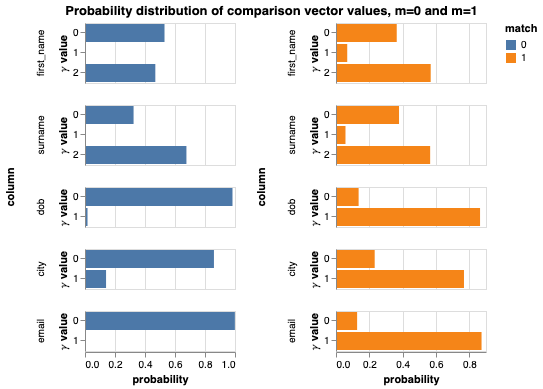

In [9]:
params = linker.params
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

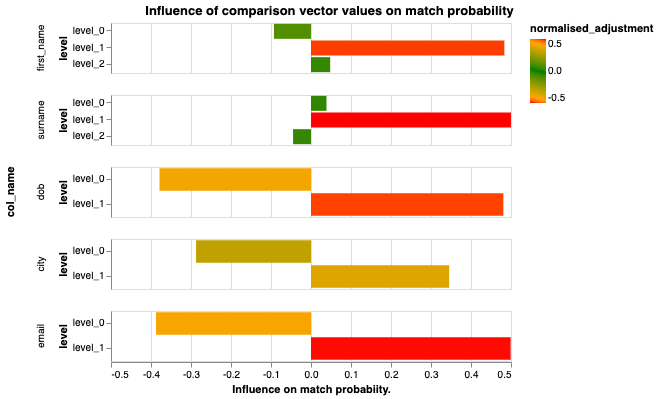

In [10]:
params.adjustment_factor_chart()

In [ ]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
params.all_charts_write_html_file()

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [11]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.4163132905960083

Comparison of first_name.  Values are:
first_name_l: None
first_name_r: Ryan 
Comparison has 3 levels
𝛾 for this comparison = gamma_first_name = -1
Amongst matches, P(𝛾 = 1.0):
Amongst non matches, P(𝛾 = 1.0):
Adjustment factor = p1/(p1 + p2) = 0.5
New probability of match (updated belief): 0.4163132905960083

Comparison of surname.  Values are:
surname_l: Turner
surname_r: None
Comparison has 3 levels
𝛾 for this comparison = gamma_surname = -1
Amongst matches, P(𝛾 = 1.0):
Amongst non matches, P(𝛾 = 1.0):
Adjustment factor = p1/(p1 + p2) = 0.5
New probability of match (updated belief): 0.4163132905960083

Comparison of dob.  Values are:
dob_l: 1990-03-21
dob_r: 1990-03-21
Comparison has 2 levels
𝛾 for this comparison = gamma_dob = 1
Amongst matches, P(𝛾 = 0.8642963767051697):
Amongst non matches, P(𝛾 = 0.016823219135403633):
Adjustment factor = p1/(p1 + p2) = 0.9809069969447739
New probability of match (updated belief): 0.

## Step 7: Term frequency adjustments

Splink enables you to make adjustments for term frequency on any number of columns

This enables match probabilities to be adjusted for e.g. the fact John Smith is more prevalent than Robin Linacre

In [ ]:
df_e_adj = linker.make_term_frequency_adjustments(df_e)

In [ ]:
pdtf = df_e_adj.toPandas()
sam = pdtf.sample(10)
sam[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

In [ ]:
sam